This notebook demonstrates how to:

1. Analyze CESM2 NetCDF structure
   - Load CESM2 precipitation data (PRECT) with xarray/geowombat
   - Examine dimensions, temporal range, and spatial coverage
   
2. Export time series data to raster files
   - Export 1 year of daily data as individual GeoTIFFs
   - Maintain temporal ordering and geospatial context
   
3. Extract features with xr_fresh
   - Configure comprehensive feature set for precipitation data
   - Run parallel feature extraction on daily precipitation time series
   - Generate feature rasters for climate analysis

In [1]:
import os
import numpy as np
import pandas as pd
from glob import glob
from pathlib import Path
import xarray as xr
import rasterio
from rasterio.transform import from_bounds
from xr_fresh.feature_calculator_series import *
from xr_fresh.extractors_series import extract_features_series


def analyze_cesm2_netcdf(netcdf_path):
    """Analyze the structure of the CESM2 NetCDF file"""
    print(f"Analyzing CESM2 dataset: {netcdf_path}")
    
    ds = xr.open_dataset(netcdf_path)
    
    print(f"\nDimensions: {dict(ds.dims)}")
    print(f"Coordinates: {list(ds.coords)}")
    print(f"Data variables: {list(ds.data_vars)}")
    
    # Check PRECT variable
    if 'PRECT' in ds.data_vars:
        prect = ds.PRECT
        print(f"\nPRECT (Total Precipitation Rate):")
        print(f"  Shape: {prect.shape}")
        print(f"  Dimensions: {prect.dims}")
        print(f"  Time range: {ds.time.values[0]} to {ds.time.values[-1]}")
        print(f"  Number of time steps: {len(ds.time)}")
        print(f"  Spatial extent: {float(ds.lat.min()):.2f}° to {float(ds.lat.max()):.2f}° lat")
        print(f"                  {float(ds.lon.min()):.2f}° to {float(ds.lon.max()):.2f}° lon")
        print(f"  Resolution: {len(ds.lat)} x {len(ds.lon)} grid")
        print(f"  Units: {prect.attrs.get('units', 'N/A')}")
        
        # Show data stats
        sample = prect.isel(time=0).values
        print(f"\n  Sample statistics (first timestep):")
        print(f"    Min: {np.nanmin(sample):.6e}, Max: {np.nanmax(sample):.6e}")
        print(f"    Mean: {np.nanmean(sample):.6e}")
    
    return ds

# Analyze the CESM2 NetCDF file (small version with 3 years of data)
nc_path = '../xr_fresh/data/ppt_SSP245_NCAR_CESM2_small.nc'
ds = analyze_cesm2_netcdf(nc_path)

/home/mmann1123/miniconda3/envs/xr_fresh/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Analyzing CESM2 dataset: ../xr_fresh/data/ppt_SSP245_NCAR_CESM2_small.nc

Dimensions: {'time': 366, 'lat': 192, 'lon': 288}
Coordinates: ['lat', 'lon', 'time']
Data variables: ['PRECT']

PRECT (Total Precipitation Rate):
  Shape: (366, 192, 288)
  Dimensions: ('time', 'lat', 'lon')
  Time range: 2015-01-01 00:00:00 to 2016-01-01 00:00:00
  Number of time steps: 366
  Spatial extent: -90.00° to 90.00° lat
                  0.00° to 358.75° lon
  Resolution: 192 x 288 grid
  Units: m/s

  Sample statistics (first timestep):
    Min: 0.000000e+00, Max: 4.116786e-06
    Mean: 2.279908e-08


In [2]:
def export_cesm2_to_rasters(netcdf_path, output_dir):
    """
    Export CESM2 PRECT data to individual raster files for xr_fresh processing.
    
    Parameters:
    -----------
    netcdf_path : str
        Path to the CESM2 NetCDF file (uses all time steps in file)
    output_dir : str
        Directory to save raster files
    """
    
    # Create output directory
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    print(f"Exporting CESM2 PRECT data from {netcdf_path}")
    print(f"Output directory: {output_dir}")
    
    # Open dataset
    ds = xr.open_dataset(netcdf_path)
    
    # Use all PRECT data in the file
    prect = ds.PRECT
    
    print(f"Time steps to export: {len(prect.time)}")
    print(f"Date range: {prect.time.values[0]} to {prect.time.values[-1]}")
    
    # Get spatial information
    lats = ds.lat.values
    lons = ds.lon.values
    
    # Create geotransform
    west, east = float(lons.min()), float(lons.max())
    south, north = float(lats.min()), float(lats.max())
    
    height, width = len(lats), len(lons)
    transform = from_bounds(west, south, east, north, width, height)
    
    successful_files = []
    
    # Export each time step as a raster
    for i, time_val in enumerate(prect.time.values):
        try:
            # Handle cftime objects - convert to string for filename
            if hasattr(time_val, 'strftime'):
                # cftime object
                time_str = time_val.strftime('%Y%m%d')
            else:
                # pandas Timestamp
                time_pd = pd.to_datetime(str(time_val))
                time_str = time_pd.strftime('%Y%m%d')
            
            filename = f"PRECT_{time_str}.tif"
            filepath = output_path / filename
            
            # Get data for this timestep
            raster_data = prect.isel(time=i).values.astype(np.float32)
            
            # Write raster file
            with rasterio.open(
                filepath,
                'w',
                driver='GTiff',
                height=height,
                width=width,
                count=1,
                dtype=rasterio.float32,
                crs='EPSG:4326',
                transform=transform,
                compress='lzw',
                nodata=np.nan
            ) as dst:
                dst.write(raster_data, 1)
            
            successful_files.append(str(filepath))
            
            if i % 100 == 0 or i < 5:  # Show progress
                print(f"  Exported: {filename} (mean: {np.nanmean(raster_data):.6e})")
                
        except Exception as e:
            print(f"  Failed {filename}: {e}")
    
    print(f"\n✓ Successfully exported {len(successful_files)} raster files")
    print(f"  Files saved to: {output_dir}/")
    
    ds.close()
    return successful_files

# Export all CESM2 precipitation data from the small file (1 year, 2015)
output_directory = 'cesm2_prect_series'

exported_files = export_cesm2_to_rasters(nc_path, output_directory)

Exporting CESM2 PRECT data from ../xr_fresh/data/ppt_SSP245_NCAR_CESM2_small.nc
Output directory: cesm2_prect_series
Time steps to export: 366
Date range: 2015-01-01 00:00:00 to 2016-01-01 00:00:00
  Exported: PRECT_20150101.tif (mean: 2.279908e-08)
  Exported: PRECT_20150102.tif (mean: 2.587878e-08)
  Exported: PRECT_20150103.tif (mean: 2.646894e-08)
  Exported: PRECT_20150104.tif (mean: 2.674401e-08)
  Exported: PRECT_20150105.tif (mean: 2.644001e-08)
  Exported: PRECT_20150411.tif (mean: 2.647164e-08)
  Exported: PRECT_20150411.tif (mean: 2.647164e-08)
  Exported: PRECT_20150720.tif (mean: 2.858956e-08)
  Exported: PRECT_20150720.tif (mean: 2.858956e-08)
  Exported: PRECT_20151028.tif (mean: 2.850619e-08)
  Exported: PRECT_20151028.tif (mean: 2.850619e-08)

✓ Successfully exported 366 raster files
  Files saved to: cesm2_prect_series/

✓ Successfully exported 366 raster files
  Files saved to: cesm2_prect_series/


In [3]:
# Prepare file list and dates for feature extraction
from glob import glob
from datetime import datetime
import pandas as pd

# Get list of exported raster files
file_glob = "./cesm2_prect_series/PRECT_*.tif"
strp_glob = "./cesm2_prect_series/PRECT_%Y%m%d.tif"

raster_files = sorted(glob(file_glob))
dates = sorted(
    datetime.strptime(string, strp_glob) for string in raster_files
)

# Display file information
print(f"Total files: {len(raster_files)}")
print(f"Date range: {dates[0]} to {dates[-1]}")
print(f"Duration: {(dates[-1] - dates[0]).days} days\n")

# Show sample of files
df = pd.DataFrame({"date": dates, "file": raster_files})
print(df.head(10))
print("...")
print(df.tail(5))

Total files: 1096
Date range: 2015-01-01 00:00:00 to 2018-01-01 00:00:00
Duration: 1096 days

        date                                     file
0 2015-01-01  ./cesm2_prect_series/PRECT_20150101.tif
1 2015-01-02  ./cesm2_prect_series/PRECT_20150102.tif
2 2015-01-03  ./cesm2_prect_series/PRECT_20150103.tif
3 2015-01-04  ./cesm2_prect_series/PRECT_20150104.tif
4 2015-01-05  ./cesm2_prect_series/PRECT_20150105.tif
5 2015-01-06  ./cesm2_prect_series/PRECT_20150106.tif
6 2015-01-07  ./cesm2_prect_series/PRECT_20150107.tif
7 2015-01-08  ./cesm2_prect_series/PRECT_20150108.tif
8 2015-01-09  ./cesm2_prect_series/PRECT_20150109.tif
9 2015-01-10  ./cesm2_prect_series/PRECT_20150110.tif
...
           date                                     file
1091 2017-12-28  ./cesm2_prect_series/PRECT_20171228.tif
1092 2017-12-29  ./cesm2_prect_series/PRECT_20171229.tif
1093 2017-12-30  ./cesm2_prect_series/PRECT_20171230.tif
1094 2017-12-31  ./cesm2_prect_series/PRECT_20171231.tif
1095 2018-01-01  ./cesm

In [6]:
import time
start_time = time.time()
# Define feature set for precipitation time series analysis
# Note: Excluding longest_strike features due to JAX tracer compatibility
feature_list = {
    # Basic statistics
    "minimum": [{}],
    "maximum": [{}],
    "mean": [{}],
    "median": [{}],
    "standard_deviation": [{}],
    "sum": [{}],  # Total precipitation over the year
    
    # Temporal features
    "doy_of_maximum": [{"dates": dates}],  # Day of year with max precipitation
    "doy_of_minimum": [{"dates": dates}],  # Day of year with min precipitation
    
    # Variability and change
    "mean_abs_change": [{}],  # Average absolute day-to-day change
    "absolute_sum_of_changes": [{}],  # Total variability
    "variance": [{}],
    "mean_change": [{}],  # Average day-to-day change
    
    # Distribution features  
    "skewness": [{}],  # Distribution asymmetry (right-skewed = more extreme events)
    "kurtosis": [{}],  # Distribution tail heaviness (high = more extremes)
    "quantile": [{"q": 0.25}, {"q": 0.75}, {"q": 0.9}, {"q": 0.95}],  # Precipitation quantiles
    
    # Complexity and energy
    "ts_complexity_cid_ce": [{}],  # Time series complexity
    "abs_energy": [{}],  # Sum of squared values
    
    # Threshold features (useful for precipitation)
    "count_above_mean": [{}],  # Days above average precipitation
    "count_below_mean": [{}],  # Days below average precipitation
    "ratio_beyond_r_sigma": [{"r": 1}, {"r": 2}],  # Extreme precipitation events (1 and 2 std devs)
    
    # Additional useful features
    "variance_larger_than_standard_deviation": [{}],  # Variability indicator
}

print(f"Feature categories: {len(feature_list)}")

# Define band name for output files
band_name = "PRECT"

# Run feature extraction
print("\nStarting feature extraction...")
print("Note: This may take several minutes for 1 year of global daily data...")

extract_features_series(
    raster_files,
    feature_list,
    band_name,
    "cesm2_prect_series/features",
    num_workers=8,  # Adjust based on your CPU cores
    nodata=np.nan
)

print("\n✓ Feature extraction completed!")
print("Results saved to: cesm2_prect_series/features/")

end_time = time.time()
print(f"Total time: {end_time - start_time:.2f} seconds")

Feature categories: 21

Starting feature extraction...
Note: This may take several minutes for 1 year of global daily data...


100%|██████████| 2/2 [00:00<00:00, 3247.62it/s]


✓ Feature extraction completed!
Results saved to: cesm2_prect_series/features/
Total time: 10.87 seconds


Generated 25 feature files:
  - PRECT_abs_energy.tif
  - PRECT_absolute_sum_of_changes.tif
  - PRECT_count_above_mean.tif
  - PRECT_count_below_mean.tif
  - PRECT_doy_of_maximum_dates.tif
  - PRECT_doy_of_minimum_dates.tif
  - PRECT_kurtosis.tif
  - PRECT_maximum.tif
  - PRECT_mean.tif
  - PRECT_mean_abs_change.tif


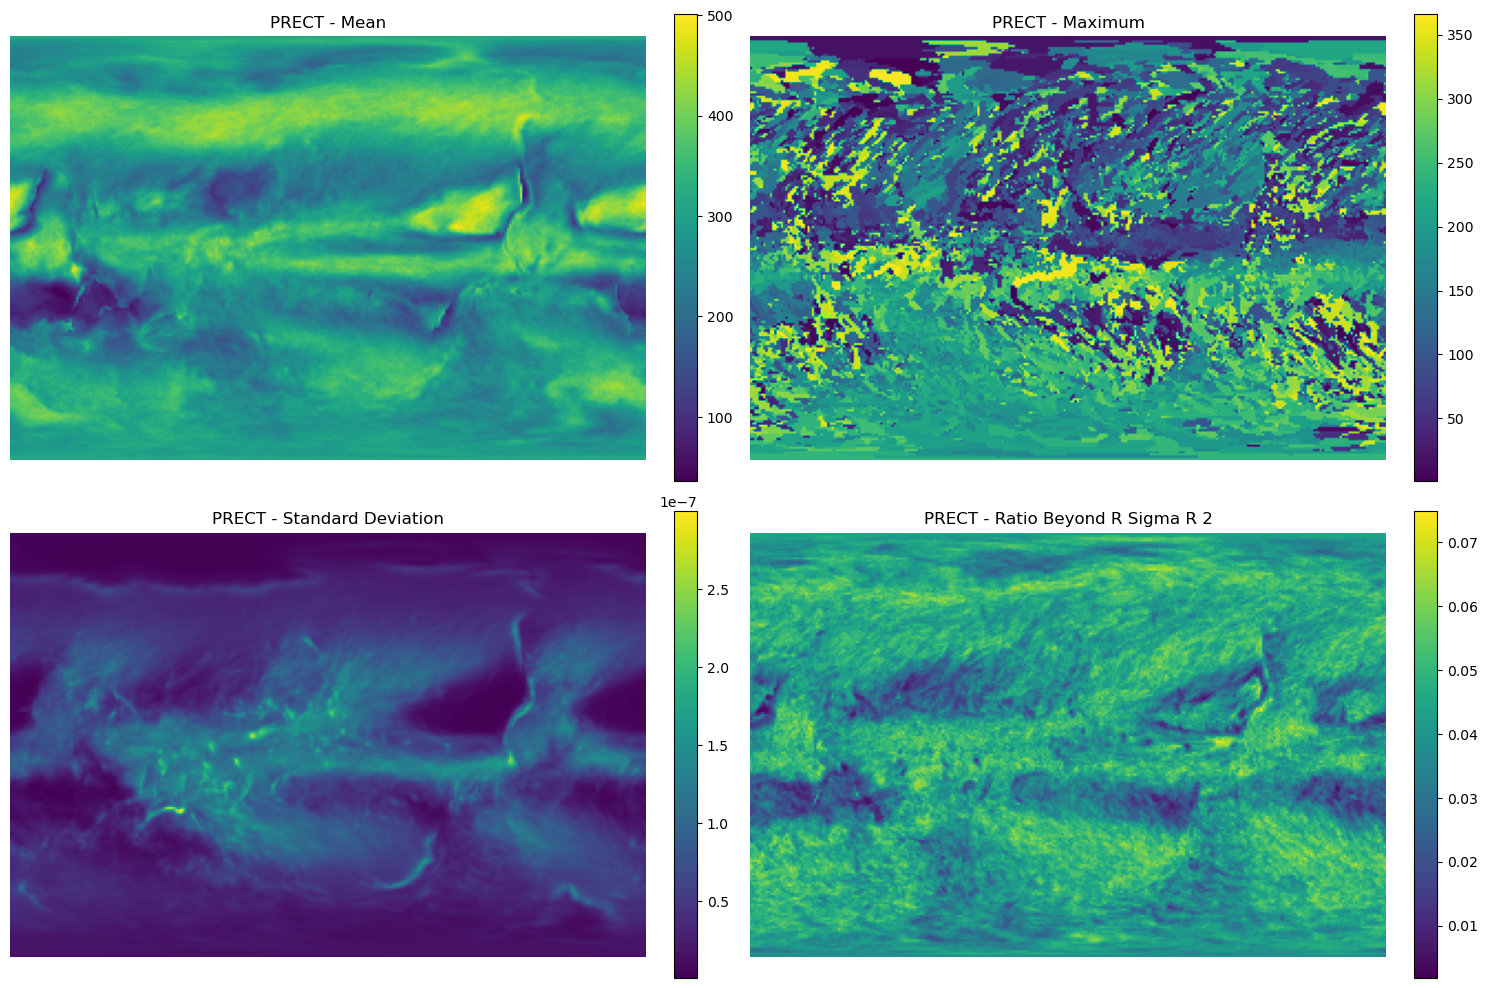


✓ Visualization saved to: cesm2_prect_series/precipitation_features.png


In [7]:
# Optional: Visualize some features
import matplotlib.pyplot as plt
import rasterio
from glob import glob

# Get feature files
feature_files = sorted(glob("cesm2_prect_series/features/PRECT_*.tif"))

if feature_files:
    print(f"Generated {len(feature_files)} feature files:")
    for f in feature_files[:10]:  # Show first 10
        print(f"  - {Path(f).name}")
    
    # Visualize a few key features
    key_features = ['mean', 'maximum', 'standard_deviation', 'ratio_beyond_r_sigma_r_2']
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, feature_name in enumerate(key_features):
        # Find the feature file
        feature_file = [f for f in feature_files if feature_name in f]
        
        if feature_file:
            with rasterio.open(feature_file[0]) as src:
                data = src.read(1)
                
                im = axes[idx].imshow(data, cmap='viridis')
                axes[idx].set_title(f'PRECT - {feature_name.replace("_", " ").title()}')
                axes[idx].axis('off')
                plt.colorbar(im, ax=axes[idx], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.savefig('cesm2_prect_series/precipitation_features.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n✓ Visualization saved to: cesm2_prect_series/precipitation_features.png")
else:
    print("No feature files found. Please run the feature extraction cell first.")